# Heart Failure Clinical Records Dataset - Lab 6

#### MinMax Normalization

In [1]:
import ds_functions as ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score
import random

data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
original_data = data.copy()
target = 'DEATH_EVENT'

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
norm_data_minmax = pd.DataFrame(transf.transform(data), columns= data.columns)


### Balancing

In [2]:
def balancing(trnX, trnY, undersample, oversample):
    #undersample, oversample = 1,0 => undersample
    #undersample, oversample = 0,1 => oversample
    unique, counts = np.unique(trnY, return_counts=True)
    
    min_positive_counts = min(counts)
    min_negative_counts = max(counts)+(min(counts)-max(counts))*undersample
    newtrnY: np.ndarray = []
    newtrnX: np.ndarray = []
    for idx in range(len(trnY)):
        if min_positive_counts > 0 and trnY[idx] == 1:
            newtrnY.append(trnY[idx])
            newtrnX.append(trnX[idx])
            min_positive_counts -= 1
        elif min_negative_counts > 0 and trnY[idx] == 0:
            newtrnY.append(trnY[idx])
            newtrnX.append(trnX[idx])
            min_negative_counts -= 1
            
    unique1, counts1 = np.unique(newtrnY, return_counts=True)
    
    max_positive_counts = min(counts1)+(max(counts1)-min(counts1))*oversample
    max_negative_counts = max(counts1)
    finaltrnY: np.ndarray = []
    finaltrnX: np.ndarray = []
    negX: np.ndarray = []
    posX: np.ndarray = []
    negY: np.ndarray = []
    posY: np.ndarray = []
        
    for idx in range(len(newtrnY)):
        if newtrnY[idx] == 0:
            finaltrnY.append(newtrnY[idx])
            negY.append(newtrnY[idx])
            finaltrnX.append(newtrnX[idx])
            negX.append(newtrnX[idx])
            max_negative_counts -= 1
        elif newtrnY[idx] == 1:
            finaltrnY.append(newtrnY[idx])
            posY.append(newtrnY[idx])
            finaltrnX.append(newtrnX[idx])
            posX.append(newtrnX[idx])
            max_positive_counts -= 1

    random.seed()

    while max_negative_counts > 0:
        rand_num = random.randint(0,len(negX)-1)
        finaltrnX.append(negX[rand_num])
        finaltrnY.append(negY[rand_num])
        max_negative_counts -= 1

    while max_positive_counts > 0:
        rand_num = random.randint(0,len(posX)-1)
        finaltrnX.append(posX[rand_num])
        finaltrnY.append(posY[rand_num])
        max_positive_counts -= 1
    
    return finaltrnX, finaltrnY

In [3]:
norm_data_unbalanced = norm_data_minmax.copy()
y: np.ndarray = norm_data_unbalanced.pop(target).values
X: np.ndarray = norm_data_unbalanced.values

<h1 style="color:orange">Gradient Boosting</h1>

In [4]:
def gradient_boosting(X, y, num_splits_kfold=5, stratified=True, undersample=0, oversample=0):
    labels = pd.unique(y)
    
    # Cross-validation
    if stratified:
        cv = StratifiedKFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X, y)
    else:
        cv = KFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X)

    n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
    max_depths = [5, 10, 25]
    learning_rate = [.1, .3, .5, .7, .9]
    cols = len(max_depths)

    for train_index, test_index in cv_split:
        best = ('', 0, 0)
        last_best = 0
        best_tree = None

        trnX, tstX = X[train_index], X[test_index]
        trnY, tstY = y[train_index], y[test_index]

        # Balancing
        if 1 in (undersample, oversample):
            trnX, trnY = balancing(trnX, trnY, undersample, oversample)
        
        plt.figure()
        fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)

        for k in range(len(max_depths)):
            d = max_depths[k]
            values = {}
            for lr in learning_rate:
                yvalues = []
                for n in n_estimators:
                    gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
                    gb.fit(trnX, trnY)
                    prdY = gb.predict(tstX)
                    yvalues.append(metrics.accuracy_score(tstY, prdY))
                    if yvalues[-1] > last_best:
                        best = (d, lr, n)
                        last_best = yvalues[-1]
                        best_tree = gb
                values[lr] = yvalues
            ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Gradient Boosting with max_depth=%d'%d,
                                   xlabel='nr estimators', ylabel='accuracy', percentage=True)

        plt.show()
        print('Best results with depth=%d, learning rate=%1.2f and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

    prd_trn = best_tree.predict(trnX)
    prd_tst = best_tree.predict(tstX)
    ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)


#### Unbalanced Classification

<Figure size 600x450 with 0 Axes>

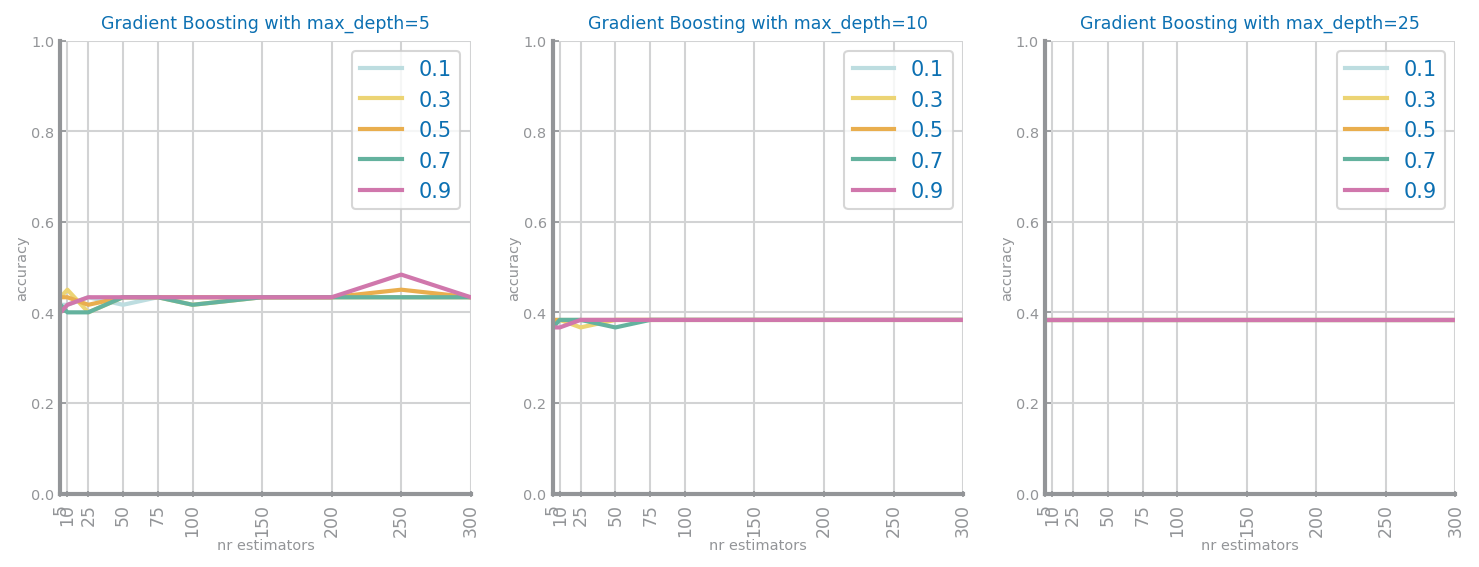

Best results with depth=5, learning rate=0.90 and 250 estimators, with accuracy=0.48


<Figure size 600x450 with 0 Axes>

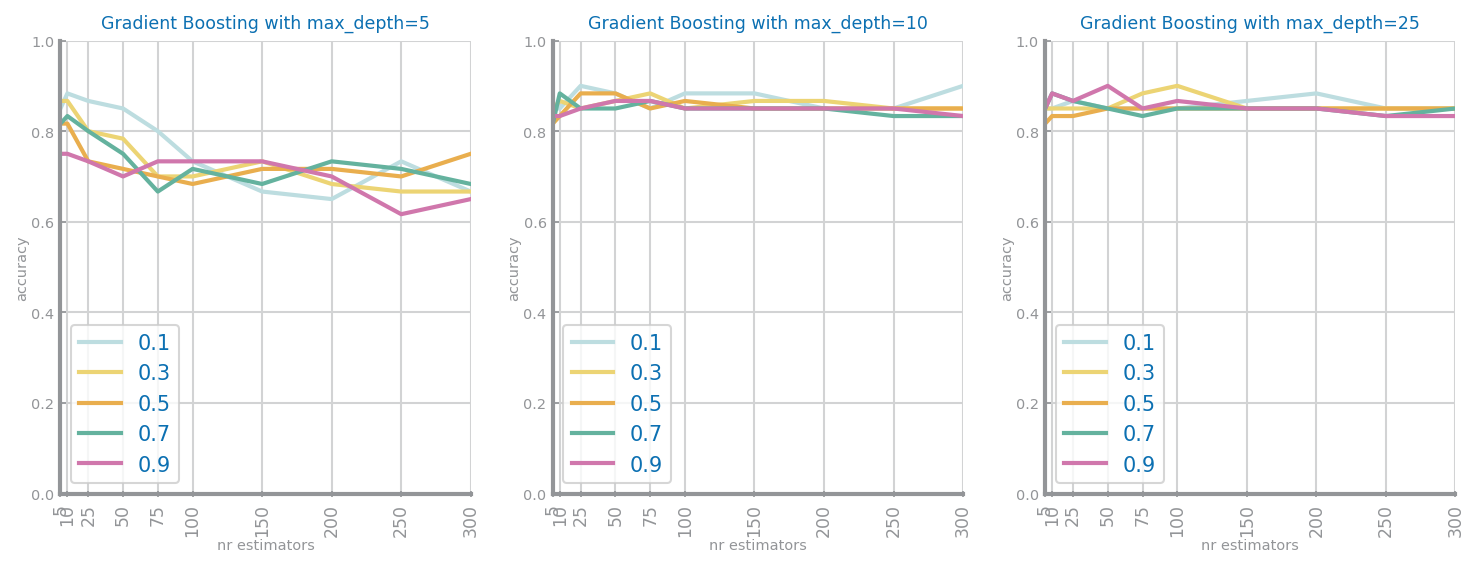

Best results with depth=10, learning rate=0.10 and 25 estimators, with accuracy=0.90


<Figure size 600x450 with 0 Axes>

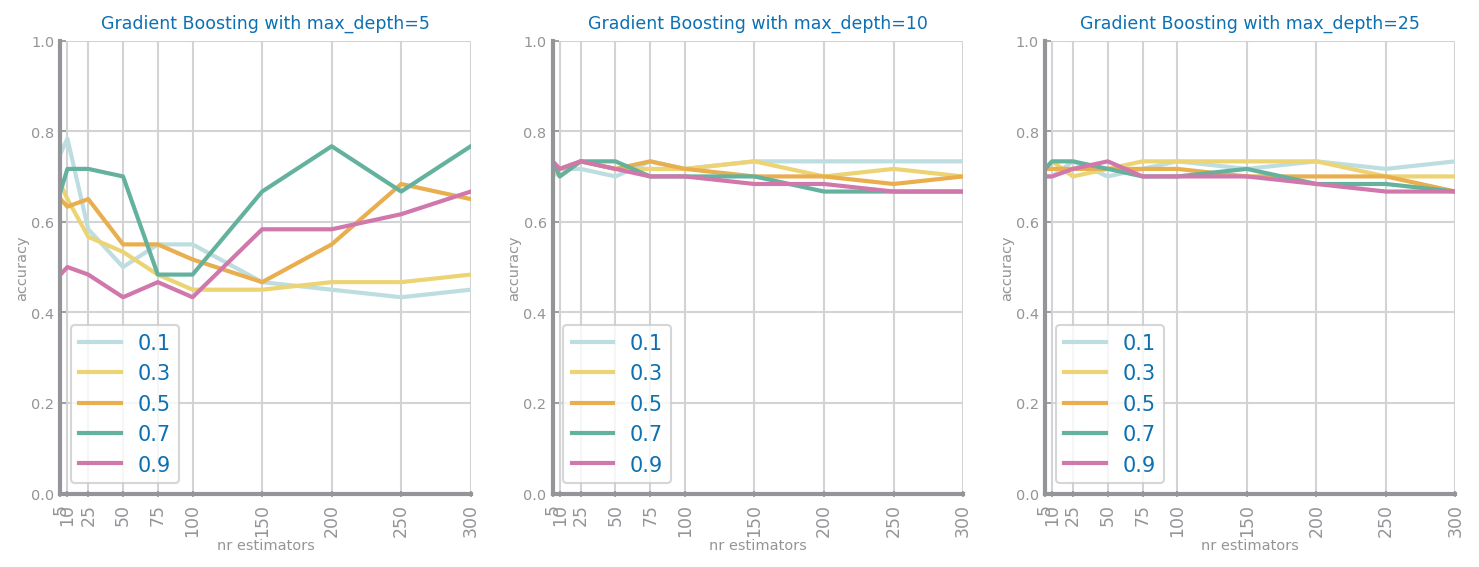

Best results with depth=5, learning rate=0.10 and 10 estimators, with accuracy=0.78


<Figure size 600x450 with 0 Axes>

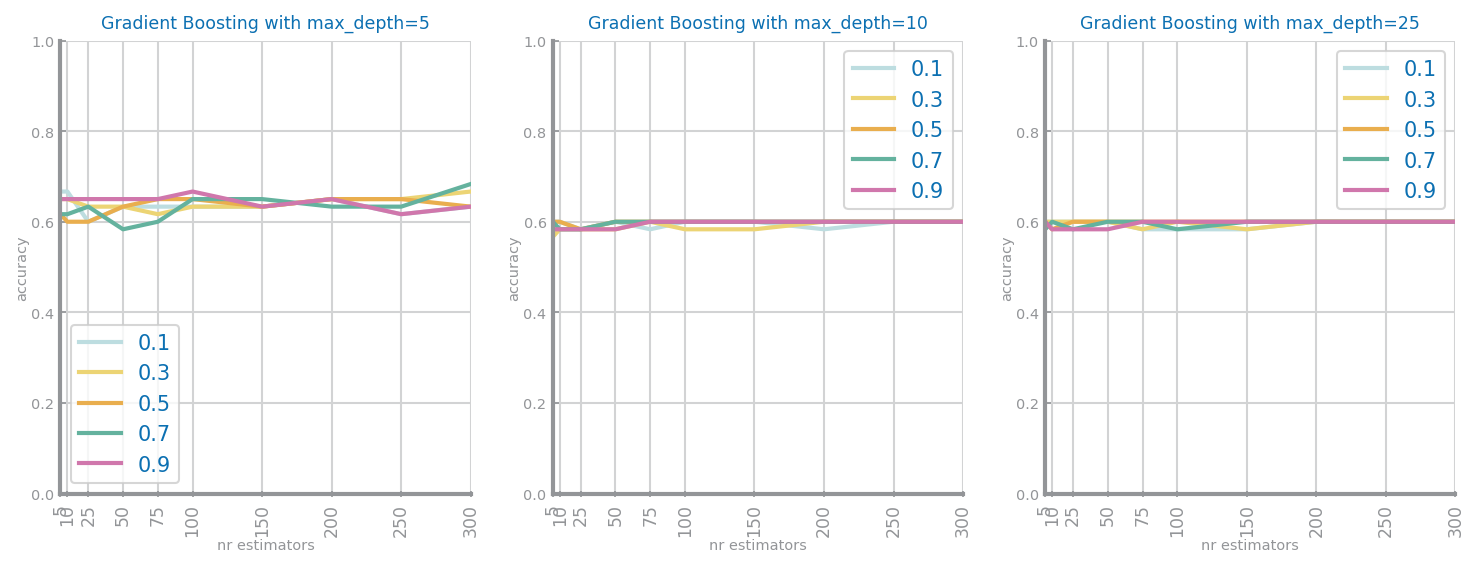

Best results with depth=5, learning rate=0.70 and 300 estimators, with accuracy=0.68


<Figure size 600x450 with 0 Axes>

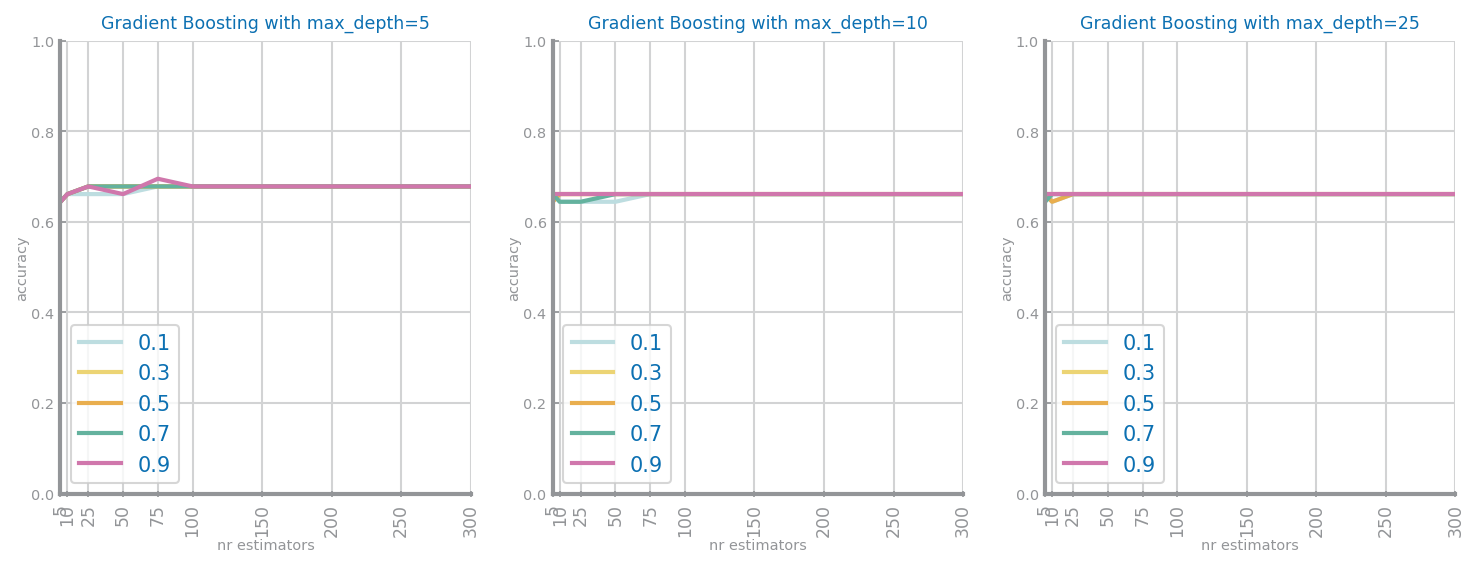

Best results with depth=5, learning rate=0.90 and 75 estimators, with accuracy=0.69
Confusion Matrix Test
TruePositives:  1
FalsePositives:  0
TrueNegatives:  40
FalseNegatives:  18


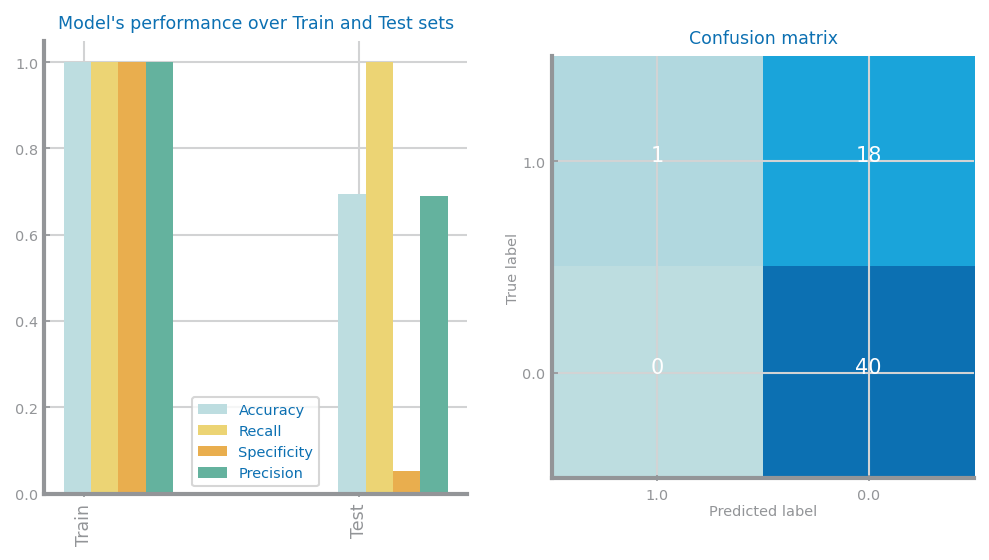

In [5]:
gradient_boosting(X, y)

#### Over Sampled Classification

<Figure size 600x450 with 0 Axes>

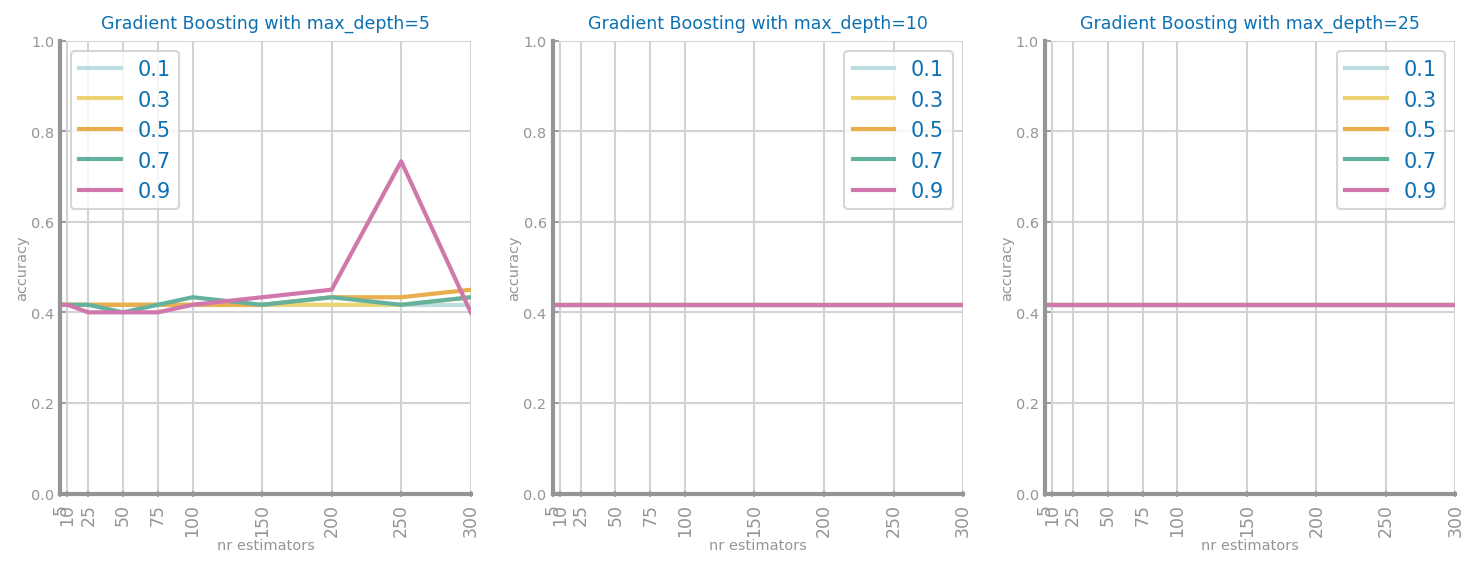

Best results with depth=5, learning rate=0.90 and 250 estimators, with accuracy=0.73


<Figure size 600x450 with 0 Axes>

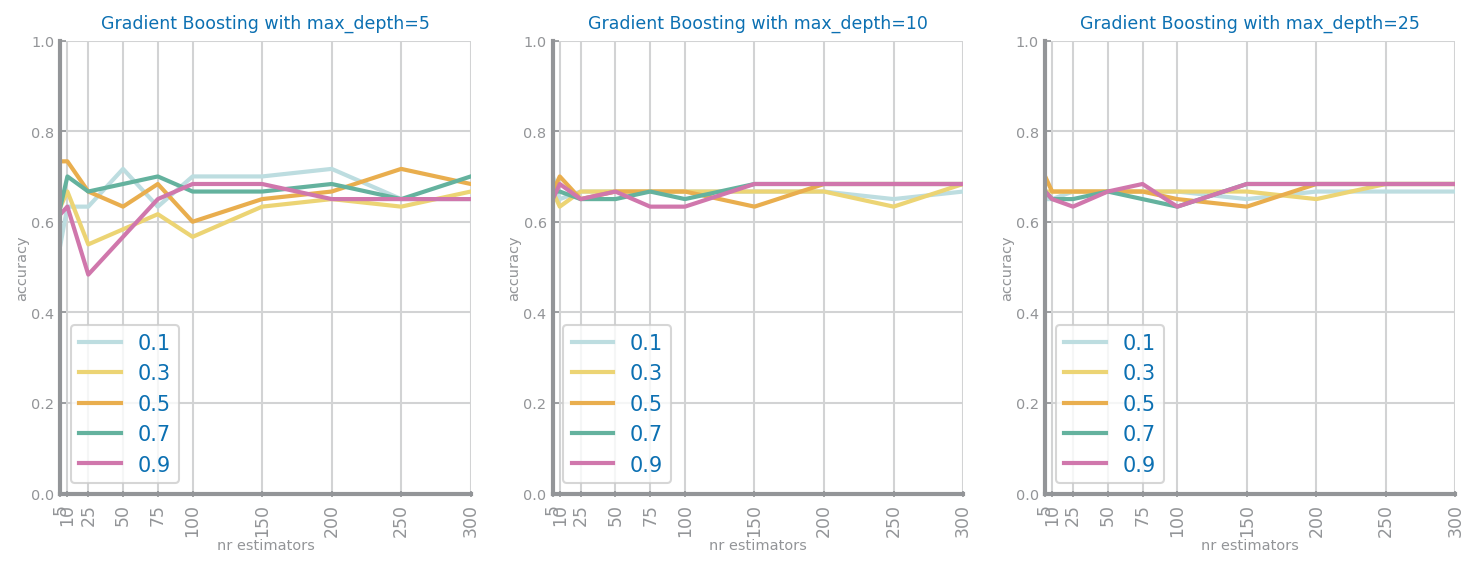

Best results with depth=5, learning rate=0.50 and 5 estimators, with accuracy=0.73


<Figure size 600x450 with 0 Axes>

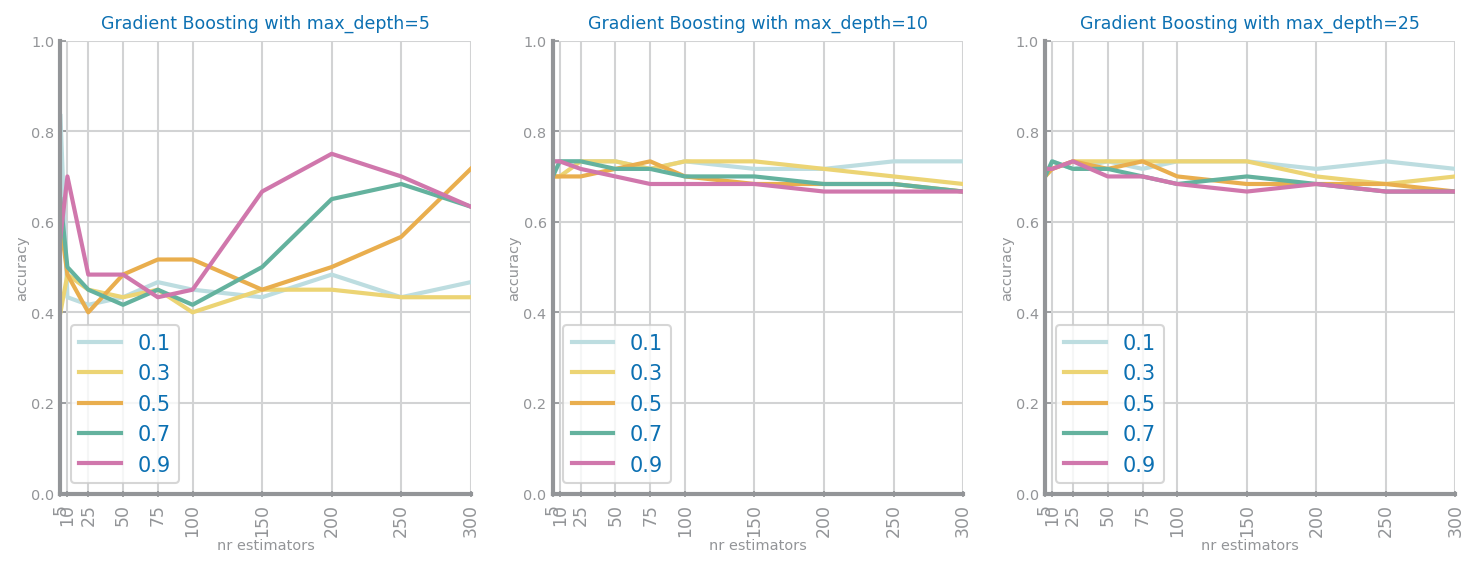

Best results with depth=5, learning rate=0.10 and 5 estimators, with accuracy=0.83


<Figure size 600x450 with 0 Axes>

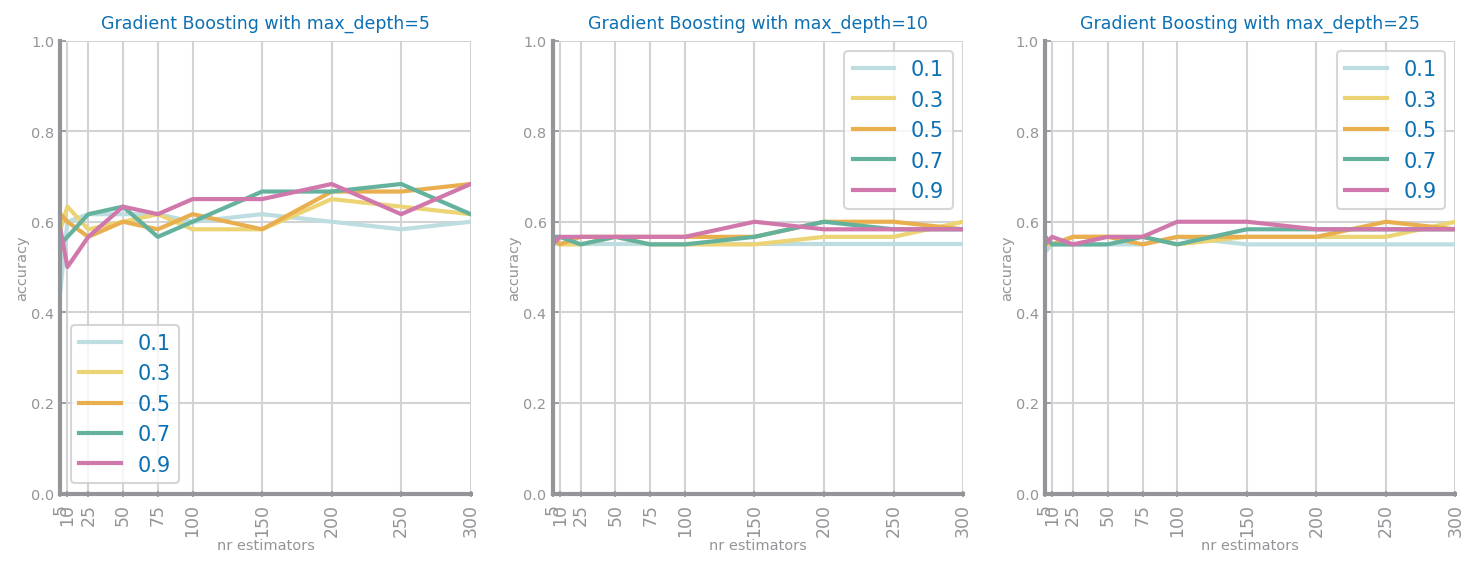

Best results with depth=5, learning rate=0.50 and 300 estimators, with accuracy=0.68


<Figure size 600x450 with 0 Axes>

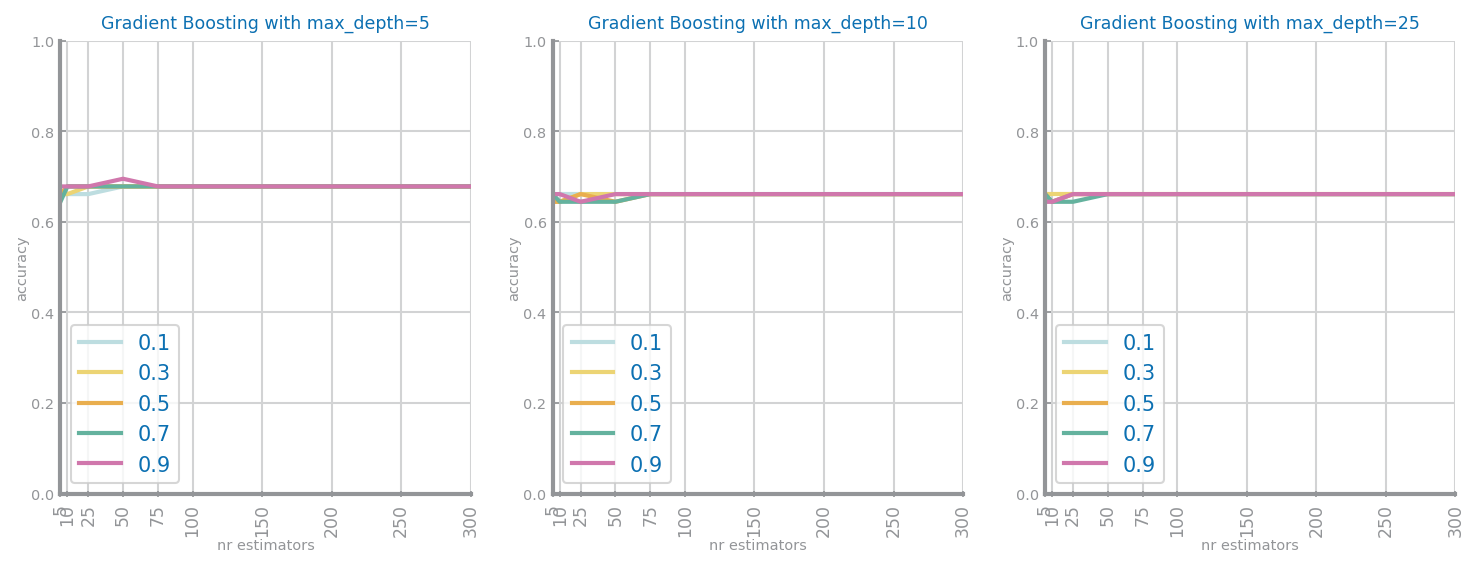

Best results with depth=5, learning rate=0.90 and 50 estimators, with accuracy=0.69
Confusion Matrix Test
TruePositives:  1
FalsePositives:  0
TrueNegatives:  40
FalseNegatives:  18


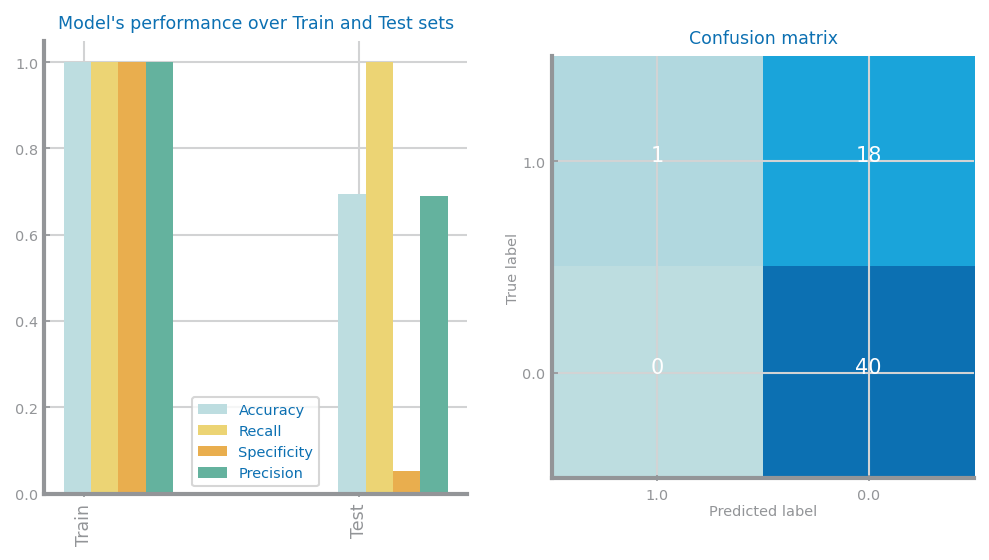

In [8]:
gradient_boosting(X, y, 5, True, 0, 1)


#### Under Sampled Classification

<Figure size 600x450 with 0 Axes>

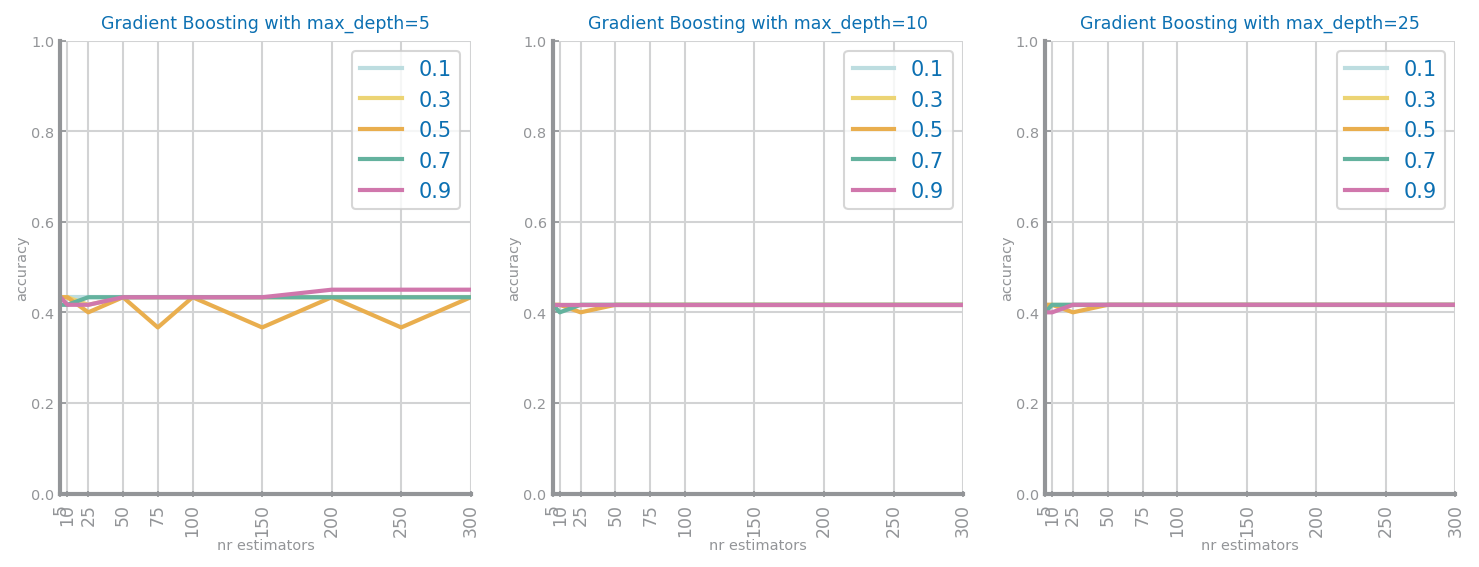

Best results with depth=5, learning rate=0.90 and 200 estimators, with accuracy=0.45


<Figure size 600x450 with 0 Axes>

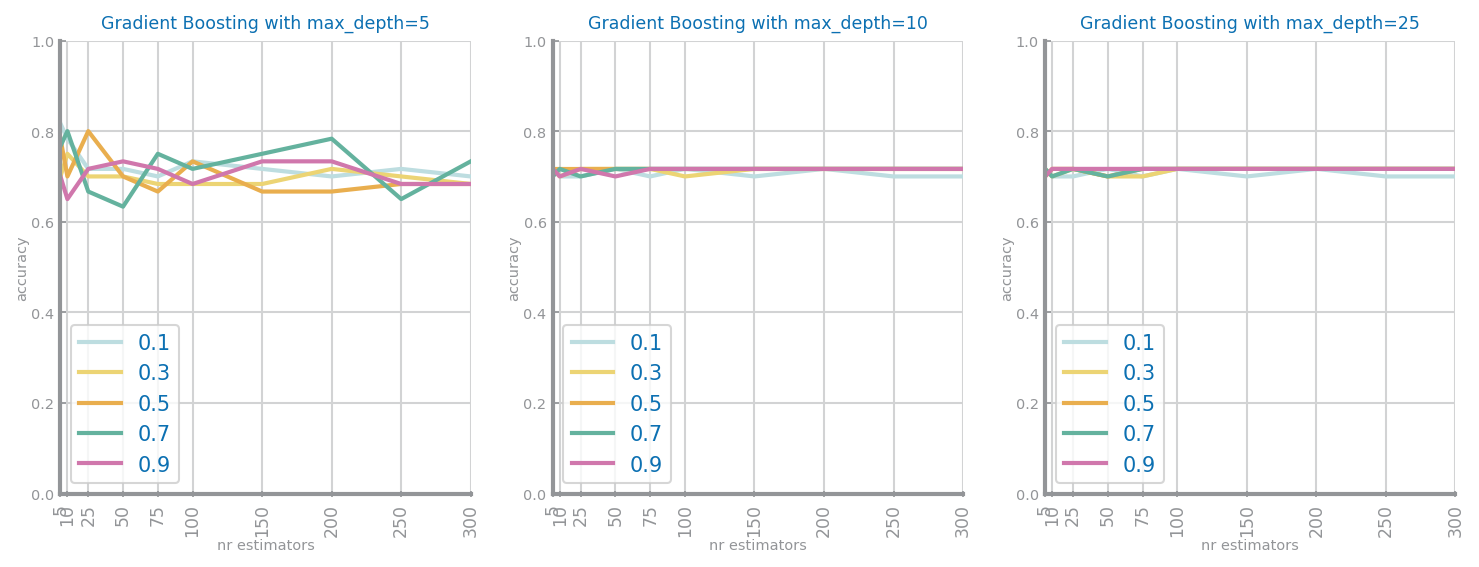

Best results with depth=5, learning rate=0.10 and 5 estimators, with accuracy=0.82


<Figure size 600x450 with 0 Axes>

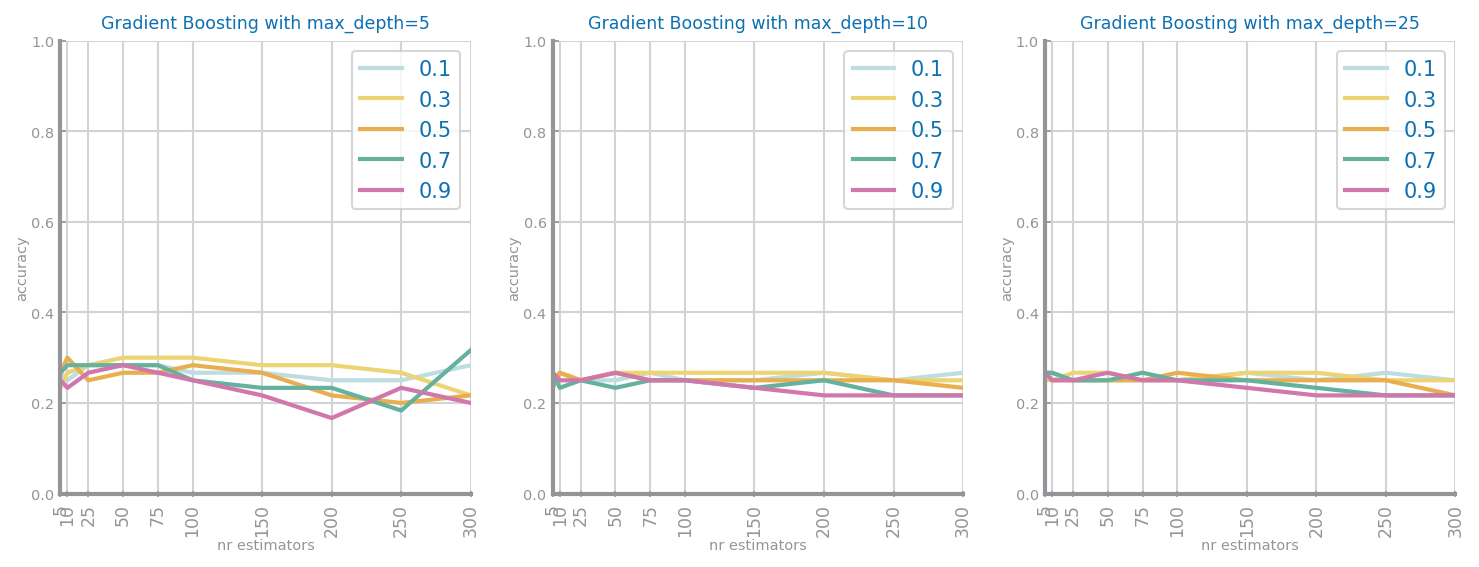

Best results with depth=5, learning rate=0.70 and 300 estimators, with accuracy=0.32


<Figure size 600x450 with 0 Axes>

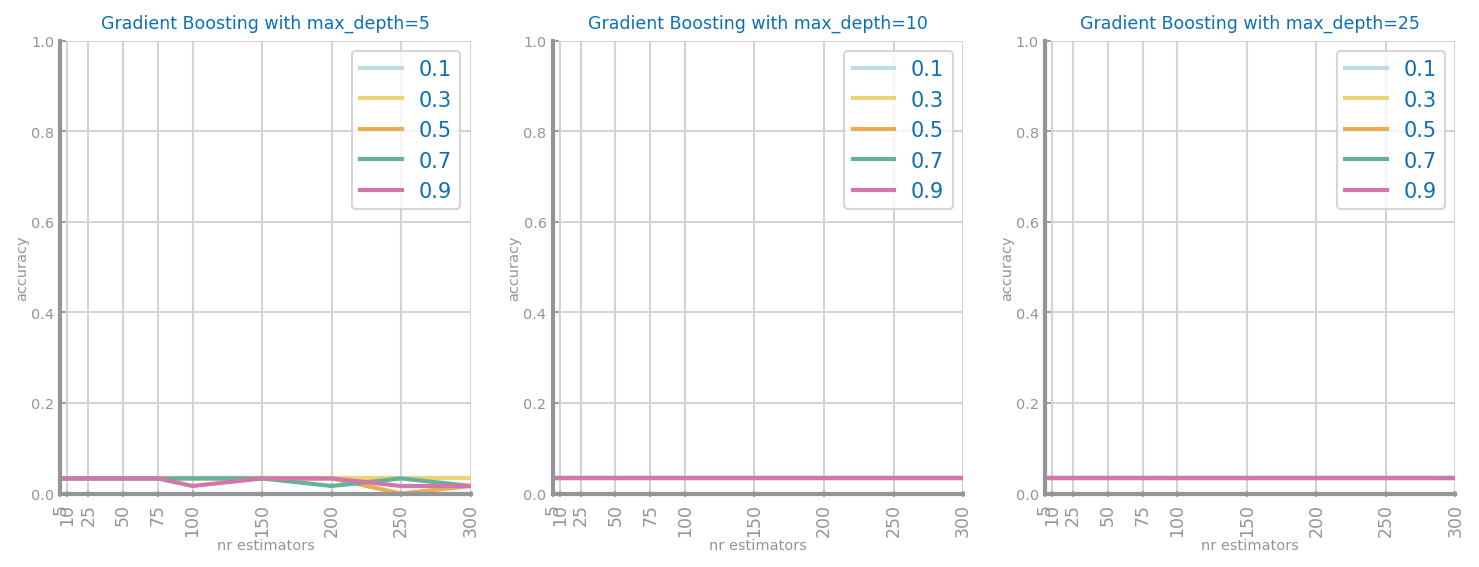

Best results with depth=5, learning rate=0.10 and 5 estimators, with accuracy=0.03


<Figure size 600x450 with 0 Axes>

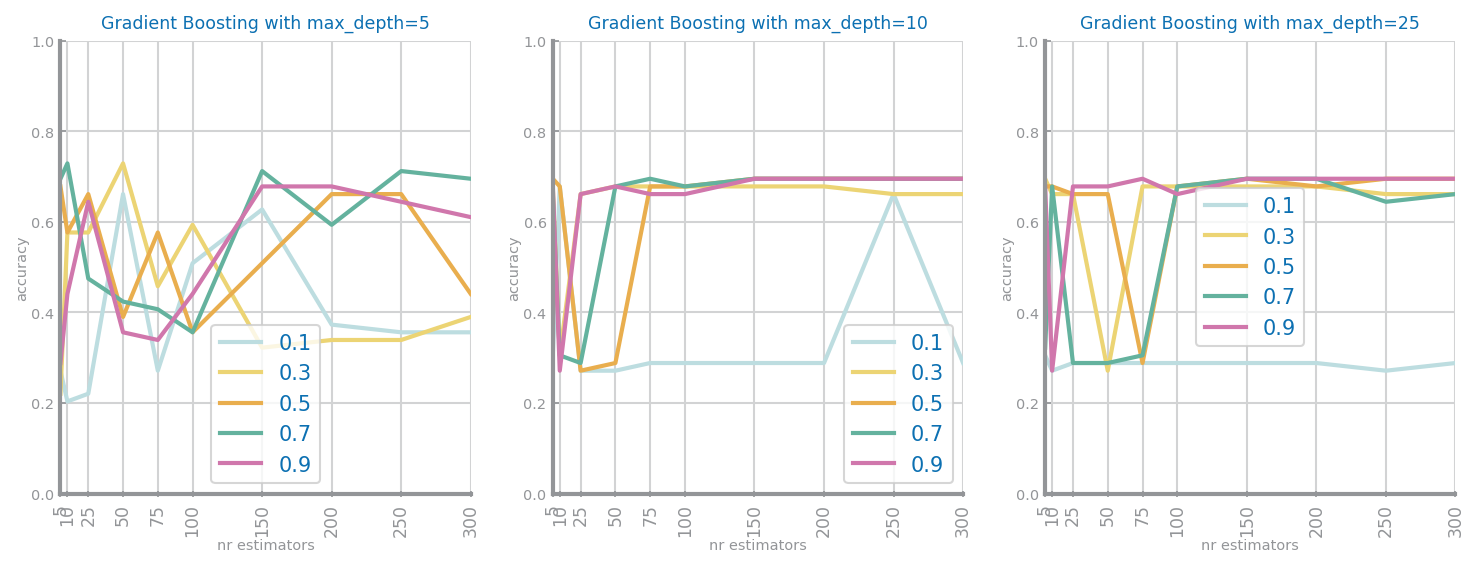

Best results with depth=5, learning rate=0.30 and 50 estimators, with accuracy=0.73
Confusion Matrix Test
TruePositives:  9
FalsePositives:  6
TrueNegatives:  34
FalseNegatives:  10


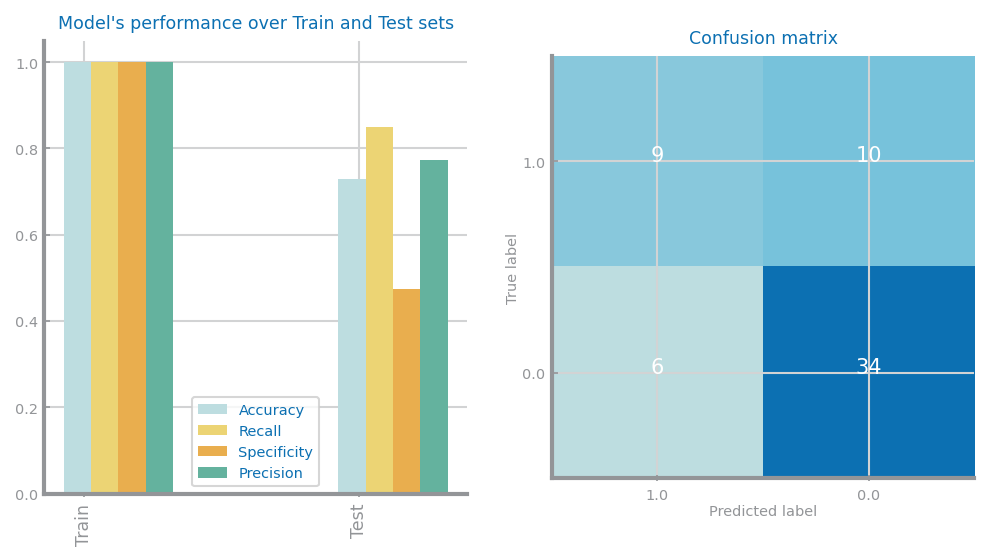

In [9]:
gradient_boosting(X, y, 5, True, 1, 0)

<h1 style="color:blue">Logistic Regression </h1>

In [28]:
precison_list = []
recall_list = []
f1_list = []
mcc_list = []

def logistic_regression_kfold(X,y,num_splits_kfold, stratified=True, undersample=0, oversample=1):

    labels = pd.unique(y)
    
    
    
    if stratified:
        cv = StratifiedKFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X, y)
    else:
        cv = KFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X)
        

    for train_index, test_index in cv_split:
                
        trnX, tstX = X[train_index], X[test_index]
        trnY, tstY = y[train_index], y[test_index]
        
        trnX_bal, trnY_bal = balancing(trnX, trnY, undersample, oversample)
        
        clf = LogisticRegression(random_state=0 , solver ='lbfgs', max_iter = 1250)
        model = clf.fit(trnX_bal, trnY_bal)

        # print(model.intercept_)
        # print(model.coef_)
        # model.score(X_train, y_train)

        predictions = model.predict(tstX)
        precison = round(precision_score(tstY,predictions),3)
        recall = round(recall_score(tstY,predictions),3)
        f1 = round(f1_score(tstY,predictions),3)
        mcc = round(matthews_corrcoef(tstY,predictions),3)
        
        precison_list.append(precison)
        recall_list.append(recall)
        f1_list.append(f1)
        mcc_list.append(mcc)
        
        print(f'\nPrecision: {precison}')
        print(f'\nRecall: {recall}')
        print(f'\nF1 Score: {f1}')
        print(f'\nMCC: {mcc}\n')
        
        
    print(len(precison_list))

    folds = range(1,6)
    
    plt.plot(folds, precison_list, label='Precision')
    plt.plot(folds, recall_list, label='Recall')
    plt.plot(folds, f1_list, label='F1 Score')
    plt.plot(folds, mcc_list, label='MCC')
    plt.legend()
    plt.title('Rate Vs Folds')
    plt.xlabel('Folds')
    plt.ylabel('Rate')
    plt.show()

In [29]:
def Average(lst): 
    return sum(lst) / len(lst)

def plot_metrics():
    max_array = [max(precison_list),max(recall_list),max(f1_list),max(mcc_list)]
    mean_array = [Average(precison_list),Average(recall_list),Average(f1_list),Average(mcc_list)]
    append_list = mean_array + max_array

    print(max_array)
    print(mean_array)

    #create toy dataframe
    df = pd.DataFrame({"Legend": ["Precision","Recall","F1 Score","MCC","Precision","Recall","F1 Score","MCC"], "clm2": np.asarray(append_list), "Max/Mean": ["Mean", "Mean", "Mean", "Mean", "Max", "Max", "Max", "Max"]})
    #rearrange dataframe and plot
    df.pivot(index = "Max/Mean", columns = "Legend", values = "clm2").plot.bar(edgecolor = "white")
    plt.xticks(rotation = 0)
    plt.show()
    

**F1 Score**: Por vezes pode ser dificil comparar 2 modelos com baixa precision e elevado recall, ou vice versa. Por outras palavras, se um modelo tem elevada precisão respetivamente a um outro modelo mas baixo recall como é que podemos determinar qual o melhor modelo? Nestes casos F1 score ajuda a medir o recall e a precision ao mesmo tempo. Utiliza a média harmónica em vez da média aritmética.

**MCC: Matthews Correlation Coeficient (MCC)** é uma métrica compreendida entre -1 e 1 em que -1 indica uma completa falha de classificação binária por parte do nosso modelo, enquanto que 1 indica uma perfeita classificação e 0 não indica que o nosso modelo não é melhor que uma metodologia de divisão random. Esta métrica permite verificar o quão bem o nosso modelo está a classificar. Esta métrica tem em consideração todos os elementos da matriz de confusão.

## Unbalanced Classification


Precision: 0.429

Recall: 0.9

F1 Score: 0.581

MCC: 0.309


Precision: 0.708

Recall: 0.895

F1 Score: 0.791

MCC: 0.687


Precision: 1.0

Recall: 0.684

F1 Score: 0.813

MCC: 0.773


Precision: 1.0

Recall: 0.579

F1 Score: 0.733

MCC: 0.696


Precision: 0.0

Recall: 0.0

F1 Score: 0.0

MCC: 0.0

5


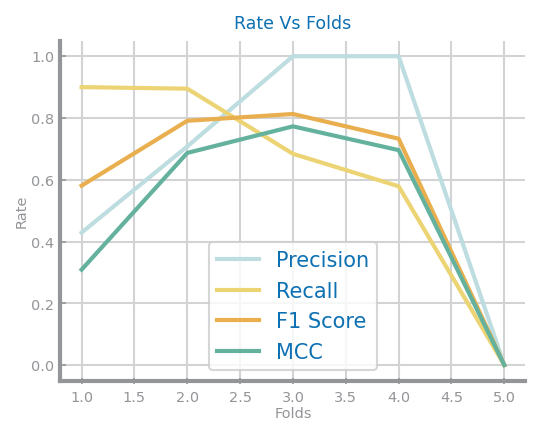

In [85]:
logistic_regression_kfold(X,y,num_splits_kfold=5, stratified=True)

[1.0, 0.9, 0.813, 0.773]
[0.6274, 0.6115999999999999, 0.5835999999999999, 0.493]


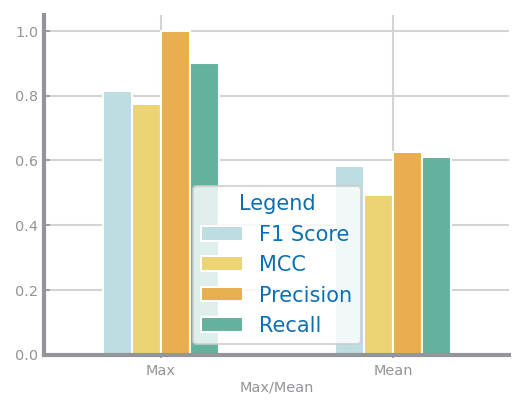

In [86]:
plot_metrics()

## Over Sampled Classification


Precision: 0.392

Recall: 1.0

F1 Score: 0.563

MCC: 0.297


Precision: 0.442

Recall: 1.0

F1 Score: 0.613

MCC: 0.428


Precision: 0.714

Recall: 0.789

F1 Score: 0.75

MCC: 0.627


Precision: 1.0

Recall: 0.789

F1 Score: 0.882

MCC: 0.848


Precision: 0.0

Recall: 0.0

F1 Score: 0.0

MCC: 0.0

5


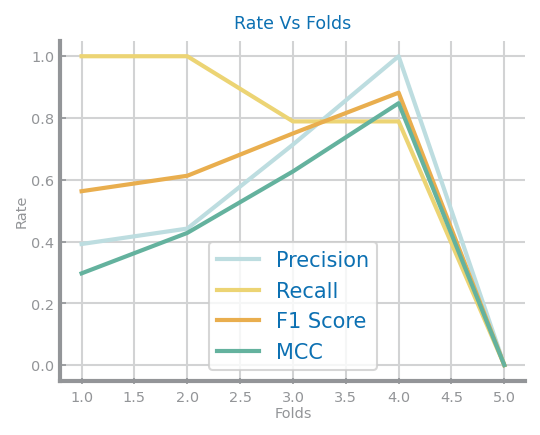

In [22]:
logistic_regression_kfold(X,y,num_splits_kfold=5, stratified=True, undersample=0, oversample=1)

[1.0, 1.0, 0.882, 0.848]
[0.5096, 0.7156, 0.5616, 0.43999999999999995]


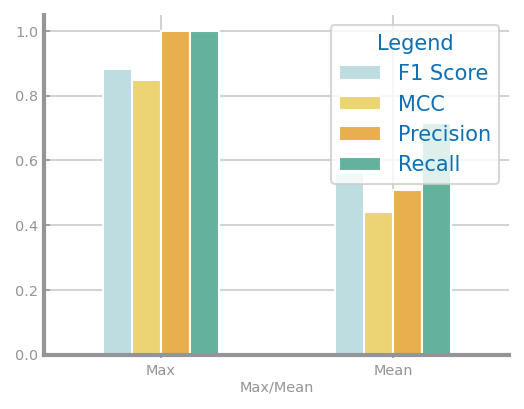

In [23]:
plot_metrics()

## Under Sampled Classification


Precision: 0.425

Recall: 0.85

F1 Score: 0.567

MCC: 0.275


Precision: 0.63

Recall: 0.895

F1 Score: 0.739

MCC: 0.609


Precision: 0.435

Recall: 0.526

F1 Score: 0.476

MCC: 0.2


Precision: 1.0

Recall: 0.474

F1 Score: 0.643

MCC: 0.617


Precision: 0.0

Recall: 0.0

F1 Score: 0.0

MCC: 0.0

5


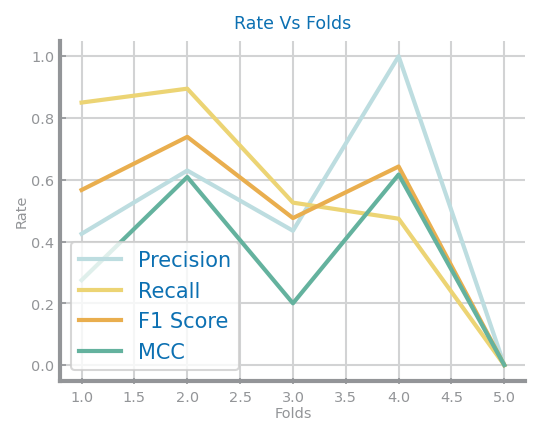

In [30]:
logistic_regression_kfold(X,y,num_splits_kfold=5, stratified=True,undersample=1, oversample=0)

[1.0, 0.895, 0.739, 0.617]
[0.49800000000000005, 0.549, 0.485, 0.3402]


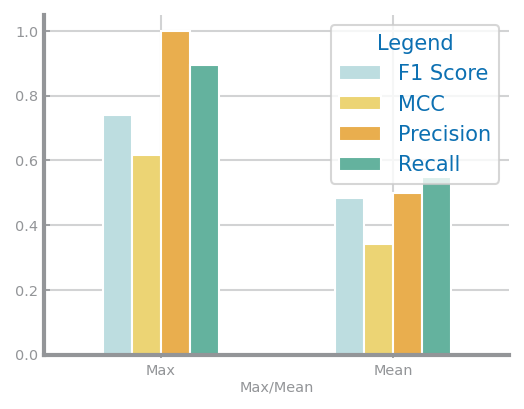

In [31]:
plot_metrics()